# Knowledge Graph based recommendation system

## 1. Load dependencies

In [1]:
# for extracting triples from raw text
!python -m pip install -q git+https://github.com/mmxgn/spacy-clausie.git

# for dowloading dataset from kaggle
!pip install -q opendatasets

     |████████████████████████████████| 769 kB 4.1 MB/s 


In [2]:
import numpy as np
import pandas as pd
import csv
import spacy
import claucy                       # for extracting triples from raw text
import os
from bs4 import BeautifulSoup       # to remove html tags
import nltk
from nltk.corpus import stopwords   # to get collection of stopwords
from tqdm import tqdm
from spacy import displacy          # for displaying big reviews
nlp = spacy.load('en_core_web_sm')


In [4]:
# https://www.geeksforgeeks.org/how-to-import-kaggle-datasets-directly-into-google-colab/
import opendatasets as od

od.download(
    "https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews")

Skipping, found downloaded files in "./amazon-fine-food-reviews" (use force=True to force download)


## 2. Load and Preprocess Dataset

In [5]:
df_raw = pd.read_csv('amazon-fine-food-reviews/Reviews.csv')
df_raw.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [6]:
df_raw.shape

(568454, 10)

**Remove duplicates**. Some reviews have every column identical except for the ProductId. This happens because these reviews refer to the same product but this product is sold in various flavours or quanitites which have different ProductIds.
<br>
The dataset will be sorted according to ProductId and then just the first similar product review will be kept while the other reviews will be deleted. This method ensures that there is only one representative for each product. Deduplication without sorting would lead to the possibility of different representatives still existing for the same product.

Example of records before de-duplication

In [7]:
records = df_raw[df_raw['UserId'] == 'A244ZOEIN2H8A7']
records.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
46112,46113,B001EO5QZK,A244ZOEIN2H8A7,David Calder,0,0,4,1287360000,Very tasty,I liked this a lot and will keep this in my te...
49579,49580,B001E5E268,A244ZOEIN2H8A7,David Calder,0,0,4,1287360000,Very tasty,I liked this a lot and will keep this in my te...
61447,61448,B001EO5R04,A244ZOEIN2H8A7,David Calder,0,0,4,1287360000,Very tasty,I liked this a lot and will keep this in my te...
61636,61637,B001EO5R0Y,A244ZOEIN2H8A7,David Calder,0,0,4,1287360000,Very tasty,I liked this a lot and will keep this in my te...
145519,145520,B003D4F1QS,A244ZOEIN2H8A7,David Calder,0,0,4,1349568000,Pleasant,This is a pleasant tea that is perfect for a r...


In [8]:
# Sort data according to ProductId in ascending order. Keep only the first ProductId of duplicate reviews
sorted_data=df_raw.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
df_big=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Summary"}, keep='first', inplace=False)
df_big.shape

(392908, 10)

Example of records after de-duplication

In [9]:
records2 = df_big[df_big['UserId'] == 'A244ZOEIN2H8A7']
records2.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
528030,528031,B000EUCKF4,A244ZOEIN2H8A7,David Calder,0,0,4,1349481600,Excellent Green Tea,I like just plain green tea and have always li...
263493,263494,B001E5E25Y,A244ZOEIN2H8A7,David Calder,0,0,4,1287360000,Very tasty,I liked this a lot and will keep this in my te...
145519,145520,B003D4F1QS,A244ZOEIN2H8A7,David Calder,0,0,4,1349568000,Pleasant,This is a pleasant tea that is perfect for a r...
460675,460676,B003ULH01I,A244ZOEIN2H8A7,David Calder,0,0,4,1310083200,Nice flavor,Numi does a good job of producing good teas an...


In [10]:
print("Duplicate records removed =",df_raw.shape[0]-df_big.shape[0])

Duplicate records removed = 175546


Remove unneeded columns

In [11]:
to_drop = ["Id","HelpfulnessNumerator","HelpfulnessDenominator","Score","Time","Summary"]
df_big.drop(to_drop,axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Remove bigger than 450 characters reviews and fix index

In [12]:
df = df_big.drop(df_big[df_big.Text.map(len) > 450].index)
df = df.reset_index()
df.drop("index", axis=1, inplace=True)
df.shape

(269432, 4)

Assign a numeric ProductId instead of the string one that exists already (it will be later useful for iterating).

In [13]:
df['ProductId'] = df.groupby(['ProductId']).ngroup()

Drop products with fewer than 30 reviews

In [14]:
df_product_ratings_count = df.groupby('ProductId').count()
df_product_ratings_count = df_product_ratings_count.iloc[:,:1]
df_product_ratings_count.rename(columns = {'UserId':'count'}, inplace = True)

In [15]:
df_product_ratings_count.head()

,count
ProductId,
0,24
1,1
2,2
3,1
4,129


In [16]:
df_product_ratings_count_min30= df_product_ratings_count.loc[df_product_ratings_count['count'] > 29]
df = df.loc[df['ProductId'].isin(df_product_ratings_count_min30.index)]
print("df shape after removal of products with less than 30 reviews:", df.shape)

df shape after removal of products with less than 30 reviews: (75547, 4)


Drop users with fewer than 3 reviews

In [17]:
df_user_ratings_count = df.groupby('UserId').count()
df_user_ratings_count = df_user_ratings_count.iloc[:,:1]
df_user_ratings_count.rename(columns = {'ProductId':'count'}, inplace = True)

In [18]:
df_user_ratings_count.head()

,count
UserId,
#oc-R103C0QSV1DF5E,1
#oc-R109MU5OBBZ59U,1
#oc-R10UA029WVWIUI,1
#oc-R11DNU2NBKQ23Z,1
#oc-R11O5J5ZVQE25C,1


In [19]:
df_user_ratings_count_min3= df_user_ratings_count.loc[df_user_ratings_count['count'] > 2]
df = df.loc[df['UserId'].isin(df_user_ratings_count_min3.index)]
print("df shape after removing users with less than 3 reviews:", df.shape)

df shape after removing users with less than 3 reviews: (10435, 4)


Remove html tags

In [20]:
# function to clean html tags in a sentence
def clean_html(sentence): 
    soup = BeautifulSoup(sentence)
    cleantext = soup.get_text()
    return cleantext

df['Text'] = df['Text'].apply(clean_html)

<br>

Let's see the final dataframe

In [21]:
df = df.reset_index()
df.drop("index", axis=1, inplace=True)
df

,ProductId,UserId,ProfileName,Text
0,4,A263978BIOCRZV,Dan Detwiler,My dogs love these treats. The only problems I...
1,4,A30M06JH5R1831,JAE,My dogs love this treat. I use it to train the...
2,4,A1YHXGV6GC51IM,"Americangirl ""TRUTH SETS YOU FREE""",ALL I DO IS SHAKE THIS CONTAINER AND MY DOG CO...
3,4,A39FLPUWTNESK0,Roy Levow,I've purchased several different brands of liv...
4,10,A370Z6I5GBWU44,"M ""CultOfStrawberry""",There's not much I can say that others haven't...
...,...,...,...,...
10430,58785,A29XI8QYHVHM7B,T. Casey,This is pretty amazing stuff. I stay away fro...
10431,58785,A1ZTHMKKOG0H6Z,J. A. Hartmann,I can't say enough good about this deliciously...
10432,58785,AH34Q0NYD4SSP,Deborah K. Anderson,"I saw this product on ""DR.OZ"" TV show & though..."
10433,58785,A38TPUN6VBAYYP,R Owens,Taking all the fat out of peanut butter and ch...


In [22]:
print("Total products left in the dataset:",df["ProductId"].nunique())
print("Total users left in the dataset:",df["UserId"].nunique())

Total products left in the dataset: 1040
Total users left in the dataset: 2300


<br>
<br>



## 3. Open Information Extraction: Create triples from the reviews

Examine the reviews

In [23]:
from pandas import option_context

df_reviews = df.filter(['Text'])
with pd.option_context('display.max_colwidth', 240):
    display(df_reviews.head(20))

,Text
0,My dogs love these treats. The only problems I've encountered with these are the left over powder at the bottom and the sizes are not uniform; many big pieces and many very small pieces (very minor problems). But they are all natural an...
1,"My dogs love this treat. I use it to train them and just for fun. The nice thing about this product is that if you want the pieces to be smaller, it's easy to cut them up without it crumbling apart. Also, it was a great deal."
2,ALL I DO IS SHAKE THIS CONTAINER AND MY DOG COMES RUNNING. SHE HAS HAD FOR OVER A YEAR AND PREFERS TO ALL TREATS AND FOOD. I FEEL GREAT AS THEY ARE GOOD FOR HER. THE PRICE SEEMS HEFTY BUT YOU CAN CUT THE PIECES UP EVEN THOUGH FREEZE DRI...
3,I've purchased several different brands of liver treats and this is the best in terms of having good-size pieces with very few small bits and little powder.
4,"There's not much I can say that others haven't said. This is a really fun film, with good writing and a cool story, along with some fun characters and creative ideas about the afterlife. I usually don't give five stars, but this movie c..."
5,"THis product did not work in my home. I do not think it was the product but we needed something different to combat fleas, like chemicals. THat's why I did not give it lower stars: I appreciate the price and quick delivery."
6,"I am not sure how bad my flea problem is, but I have seen a couple fleas on the pads. So it must work."
7,"We put this on our patio to keep flies out of the house when we use the back door, and it has really worked. No flies at all getting in now!04-20-11 UPDATE: Stilll using these every Spring & Summer for a ""no fly zone"" around our patio. ..."
8,Very good little set of colors. Very vibrant colors as well. Great price when compared to supermarket.I am very pleased.
9,I could spend a year explaining how delightful it is to have all these colors and they are a good quality and excellent value. My daughter who loves to bake turned me on to these.You will have so much fun controlling and mixing and bein...


Add an OIE tool to the spacy pipeline

In [24]:
claucy.add_to_pipe(nlp) 
nlp.pipeline

[('tok2vec', <spacy.pipeline.tok2vec.Tok2Vec at 0x7ff920169a60>),
 ('tagger', <spacy.pipeline.tagger.Tagger at 0x7ff920169910>),
 ('parser', <spacy.pipeline.dep_parser.DependencyParser at 0x7ff91fe8bdd0>),
 ('attribute_ruler',
  <spacy.pipeline.attributeruler.AttributeRuler at 0x7ff91fe9ca50>),
 ('lemmatizer',
  <spacy.lang.en.lemmatizer.EnglishLemmatizer at 0x7ff91feba730>),
 ('ner', <spacy.pipeline.ner.EntityRecognizer at 0x7ff91fe8bed0>),
 ('claucy', <function claucy.claucy.extract_clauses_doc(doc)>)]

Create at most 3 triples (Subject - Verb - Object) from each review. For a few reviews only Subject-Verb tuples are found.

In [25]:
"""
Determines if the triple is suitable to be added to the propositions
Arguments: clause (as created by claucy), propositions (list of all valid triples),
           i (the i-th review examined), not_wanted (undesirable words for the subject of triple)
"""

def examine_clause(clause, propositions, i, not_wanted):
  subj = (clause.subject).text.lower()
  if clause._get_clause_type() is 'SV' or subj in not_wanted:
    propositions[i].append(np.nan)
  else:
    propositions[i].append(clause.to_propositions(inflect=None)[0])

In [26]:
"""
Given a pandas columns of text reviews, extract at most 3 propositions from each review 
Arguments: df column of reviews, list of undesirable words for head entities, max number of triples extracted from each review
Returns: propositions
"""

def extract_triples(df_text_col, not_wanted, num_triples=3):
  
  propositions=[]
  i=0
  for text in tqdm(df_text_col):
    doc=nlp(text)

    # if the review has at least 1 triple
    if doc._.clauses:
      propositions.append([])
      subj = (doc._.clauses[0].subject).text.lower()
      
      # if the review has less than or 3 triples, add all of them
      if len(doc._.clauses) <= num_triples:
        for j in range(len(doc._.clauses)):
          examine_clause(doc._.clauses[j], propositions, i, not_wanted)

        # if only one triple was found, the positions of where the 2nd and 3rd triples would be saved must be filled with NaN
        if j is not 2:
          #need 3, reduce by one = 2
          for k in range(j,num_triples-1):            
            propositions[i].append(np.nan)

      # if the review has more than 3 triples, add only 3 triples
      else:
        for j in range(num_triples):
          examine_clause(doc._.clauses[j], propositions, i, not_wanted)
    else: 
      propositions.append(np.nan)

    #print(propositions[i])
    i+=1

  return propositions

propositions = extract_triples(df["Text"], ['who','you'])

100%|██████████| 10435/10435 [03:14<00:00, 53.58it/s]


In [27]:
# example of triples extracted, each row corresponds to a review, with commas are sperated the different triples extracted from each review
propositions[0:5]

[[(My dogs, love, these treats), nan, (The only problems, are, the left)],
 [(My dogs, love, this treat),
  (I, use, it, train, for),
  (The nice thing, is, 's)],
 [nan, (ALL, IS, SHAKE), (SHE, HAS HAD, A YEAR)],
 [(I, 've purchased, several different brands), (this, is, the best), nan],
 [(I, can say, said), nan, (This, is, a really fun film)]]

In [28]:
"""
Fuction to be used to get all the i-ths triples extracted from the reviews
Arguments: propositions list, i-th column to extract review from
Returns: a list with the i-th triple of each review
"""
def props_vertical_decomposition(propositions,col):
  decomp_props=[]

  for i in range(len(propositions)):  
    if propositions[i] is not np.nan:
      decomp_props.append(propositions[i][col])
    else:
      decomp_props.append(np.nan)

  return decomp_props

props0 = props_vertical_decomposition(propositions,0)
props1 = props_vertical_decomposition(propositions,1)
props2 = props_vertical_decomposition(propositions,2)

In [29]:
# create pandas columns that host all the first, all the second and all the third triples
df["triples0"] = props0
df["triples1"] = props1
df["triples2"] = props2

For reviews without verbs SVO triples won't be found

In [30]:
df.iloc[30:35]

,ProductId,UserId,ProfileName,Text,triples0,triples1,triples2
30,624,A3KJ9ONYM913Z,Jane Olson,Brussel's Golden Gate Ficus Indoor Bonsai Tree...,"((Gate, Ficus, Indoor, Bonsai, TreeI), (am), (...","((I), (thought), (be))","((these), (be), (more, expensive))"
31,632,A3A03I3P91BGH4,D. M. Pepper,Just got the most precious plant..SO beautiful...,NaN,NaN,NaN
32,658,A21TW3KGHTI1G0,"cybershopper ""amazon junkie""",I enjoyed this hot sauce. It does have a kick...,"((I), (enjoyed), (this, hot, sauce))","((It), (does, have), (a, kick))","((I), (found), (be))"
33,745,A3OXHLG6DIBRW8,"C. F. Hill ""CFH""","""Joseph's Original Sugar Free Maple Flavor Syr...","((Joseph, 's, Original, Sugar, Free, Maple, Fl...","((I), (Being), (diabetic))","((I), (have), (watch))"
34,745,A1HNBS6ICM87LS,Customer,Best sugar-free syrup I've ever tasted - it's ...,"((I), (tasted), (ever))","((it), ('s), (all))",NaN


Define the stop words. Some regular stopwords should not be removed here because they refer to entities or define the emotion.

In [31]:
nltk.download('stopwords')
english_stops = set(stopwords.words('english'))
english_stops.difference_update(set(['i','we','it','this','not','no']))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [32]:
"""
Initialize 3 empty lists each of length equal to the number of df rows
"""

def initialize_hrt(df_rows):
  head=[]
  relation=[]
  tail=[]

  for i in range(df_rows):
    head.append("")
    relation.append("")
    tail.append("")

  return head, relation, tail

head0, relation0, tail0 = initialize_hrt(df.shape[0])
head1, relation1, tail1 = initialize_hrt(df.shape[0])
head2, relation2, tail2 = initialize_hrt(df.shape[0])

In [33]:
"""
Get lemma of verb
eg.(was --> be), (has bought --> buy)
"""

def lemmatize_phrase_verb(text):
  doc = nlp(text)
  empty_list = []
  for token in doc:
    if token.dep_ == 'ROOT': 
      empty_list.append(token.lemma_)
  return str(' '.join(map(str,empty_list)))

In [34]:
"""
 De-punctuate a spacy span and return it as str
"""
def depunctuate(tail_spacy_span):

  text_tail = [tok for tok in tail_spacy_span if not str(tok).lower() in english_stops]
  text_tail = ' '.join(map(str,text_tail))
  return text_tail

Decide which triples will populate the knowledge graph. As the automated Open IE from unstructured text is a difficult task, not every extracted triple is semantically correct and thus cannot can be used. Some rules will be defined in order to determine which triples are eligible.

In [35]:
"""
Choose which triples will populate the knowledge graph and in what form
1. Triples including 'My' OR having 'I' as the head entity AND NOT having 'is' or 'have' as relation
   will be saved in the kg as (UserId, lemma of relation, ProductId) 
2. Triples including 'These' or 'This' or 'It' in the head entity
   will be saved in the kg as (ProductId, lemma of relation, subjective characterization) 
"""

def populate_kg(df, col, head, relation, tail):

  for i in range(df.shape[0]):
    triples_num='triples'+str(col)
    
    text = df[triples_num].iloc[i]
    
    # If a triple was extracted from the sentence
    if text is not np.nan:

      # If the triple is complete and not just a Subject-Verb
      if len(text)>=3:
        
        if str(text[0]) is "I" or "My" in str(text[0]):
          if str(text[1]) is not "is" and str(text[1]) is not "have":
            head[i]=df["UserId"].iloc[i]
            relation[i] = lemmatize_phrase_verb(str(df[triples_num].iloc[i][1]))
            tail[i]=df["ProductId"].iloc[i]
        else:

          prod_identifiers = ['This', 'These', 'It', 'this', 'these']
          for pi in prod_identifiers:
            if pi in str(text[0]):
              head[i]=df["ProductId"].iloc[i]
              relation[i] = lemmatize_phrase_verb(str(df[triples_num].iloc[i][1]))
              tail[i] = depunctuate(df[triples_num].iloc[i][2])
              break

  return head,relation,tail

In [36]:
head0, relation0, tail0 = populate_kg(df, 0, head0, relation0, tail0)
head1, relation1, tail1 = populate_kg(df, 1, head1, relation1, tail1)
head2, relation2, tail2 = populate_kg(df, 2, head2, relation2, tail2)

In [37]:
# join the lists
head = head0+head1+head2
relation = relation0+relation1+relation2
tail = tail0+tail1+tail2

<br>

## 4. Create Knowledge Graph

In [38]:
# create sparse knowledge graph
kg_df_sparse = pd.DataFrame({'source':head, 'edge':relation, 'target':tail})

In [39]:
kg_df_sparse.iloc[1120:1140]

,source,edge,target
1120,,,
1121,A2RPVYLTOWGGRP,get,8247
1122,A5ZD6FBMZQGDS,have,8247
1123,A1437CAM9CNC1E,remember,8247
1124,A5AZYUMD2HKAA,have,8247
1125,8328,be,nutritious tasty way
1126,,,
1127,,,
1128,A1SB8CXAUIKT8X,be,8334
1129,,,


Throw empty triples out of the knowledge graph. <b>Now the final knowledge graph is ready!</b>

In [40]:
nan_value = float("NaN")
kg_df_sparse.replace("", nan_value, inplace=True)
kg_df = kg_df_sparse.dropna(axis=0).reset_index(drop=True)

In [42]:
kg_df.values

array([['A263978BIOCRZV', 'love', 4],
       ['A30M06JH5R1831', 'love', 4],
       ['A39FLPUWTNESK0', 'purchase', 4],
       ...,
       ['AH34Q0NYD4SSP', 'give', 58785],
       ['A38TPUN6VBAYYP', 'recommend', 58785],
       ['A3K9Q3WL0OF7N1', 'need', 58785]], dtype=object)

In [ ]:
kg_df.shape

(14865, 3)

Create entities and relations dictionaries

In [41]:
source_list=list(kg_df['source'])
target_list=list(kg_df['target'])
edge_list=list(kg_df['edge'])

entities_list=source_list+target_list

## 5. Visualize data with Gephi

Create an in-degree directed graph by exporting the csv file to gephi. Clustering layout by modularity. Layout: ForceAtlas2

In [ ]:
#kg_df.to_csv('kg_df.csv', index = False, header=True)

![](https://drive.google.com/uc?export=view&id=1tVV8aeoTlDg1nk3-s2PGT-N57GXhYCG9)

In [43]:
# Get the 7 most common relations, the whitespace relation is the nan value and thus ommited
pd.Series(relation).value_counts()[:7]

         16120
be        4899
have      1090
love      1080
like       779
try        495
taste      431
dtype: int64

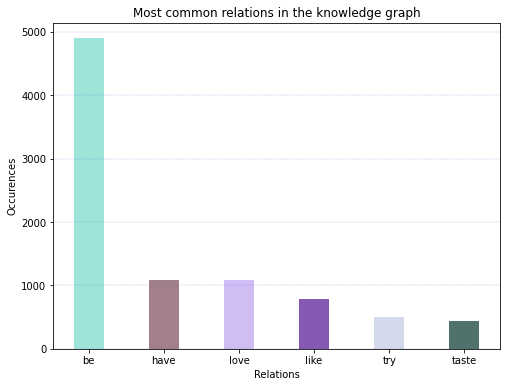

In [44]:
import matplotlib.pyplot as plt
  
values = pd.Series(relation).value_counts()[:7].values[1:]
relations = ["be", "have", "love", "like", "try","taste"]  

fig = plt.figure(figsize = (8, 6))
 
# creating the bar plot
colors = ['#9EE4D9','#a28089','#d0bdf4','#8458B3','#d3daeb','#4F726C']
plt.bar(relations, values, color =colors,
        width = 0.4)
 
plt.xlabel("Relations")
plt.ylabel("Occurences")
plt.grid(axis = 'y', color='slateblue', linestyle = '--', linewidth = 0.2)
plt.title("Most common relations in the knowledge graph")
plt.show()

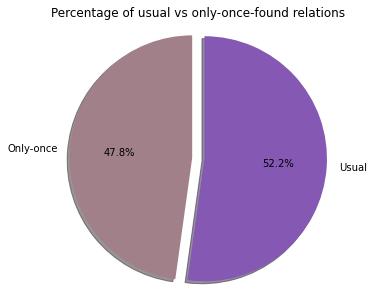

In [45]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:

labels = 'Only-once', 'Usual'
size_all = len(pd.Series(relation).value_counts().values)
size_onlyonce = np.count_nonzero(pd.Series(relation).value_counts().values == 1)
size_usual = size_all-size_onlyonce

sizes = [size_onlyonce/size_all, size_usual/size_all]
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots(figsize=(6, 5))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, colors=['#a28089','#8458B3'])
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title("Percentage of usual vs only-once-found relations")
plt.show()

## 6. Preprocess data to insert into model

Remove empty entites and relations and write the entities and the relation to seperate dictionaries.

In [46]:
edge_clean_list = [i for i in edge_list if i is not '']
dictOfRelations = { i : edge_clean_list[i] for i in range(0, len(edge_clean_list) ) }

relations_dict = {}
key = 0
for _,value in dictOfRelations.items():
    if value not in relations_dict.values():
        relations_dict[key] = value
        key+=1

In [47]:
entities_clean_list = [i for i in entities_list if i is not '']
dictOfEntities = { i : entities_clean_list[i] for i in range(0, len(entities_clean_list) ) }

entities_dict = {}
key=0
for _,value in dictOfEntities.items():
    if value not in entities_dict.values():
        entities_dict[key] = value
        key+=1

### Write dictionaries to files
In order for the model to use the data, the data will have to be written to txt files in a specific manner declared by the NicelyPrintingDict class

In [48]:
# function that exports to txt file the dictionary in a form that the model accepts
class NicelyPrintingDict():
    def __init__(self, some_dictionary):
        self.some_dictionary = some_dictionary

    def __str__(self):
        s = ''
        for key, value in self.some_dictionary.items():
            
            if key != len(self.some_dictionary)-1:
              s += str(key) + ': ' + str(value) + '\n' 
            else:
              
              s += str(key) + ': ' + str(value)
        return s.strip()

nice_entities_dict = NicelyPrintingDict(entities_dict)
nice_relations_dict = NicelyPrintingDict(relations_dict)
        

In [49]:
!pwd

/content


Create directories and write dictionaries (as txt files)

In [50]:
root='amazon-fine-food-reviews'
raw_dir=os.path.join(root, 'raw')
isExist = os.path.exists(raw_dir)

if not isExist:
  
  # Create a new directory because it does not exist 
  os.makedirs(raw_dir)

In [51]:
with open(os.path.join(raw_dir, 'relations.dict'), 'w') as f:
  print(nice_relations_dict, file=f)

with open(os.path.join(raw_dir, 'entities.dict'), 'w') as f:
  print(nice_entities_dict, file=f)

Split the knowledge graph into train, test and validaton sets (70-15-15)

In [52]:
train=kg_df.sample(frac=0.7,random_state=200) #random state is a seed value
remain=kg_df.drop(train.index)
test = remain.sample(frac=0.5,random_state=200)
valid = remain.drop(test.index)

In [53]:
print(train.shape)
print(test.shape)
print(valid.shape)

(10401, 3)
(2228, 3)
(2229, 3)


Write train, test and validaton sets to txt files

In [54]:
with open(os.path.join(raw_dir, 'train.txt'), 'w') as f:
    for line in train.values:
        line = "|".join(map(str, line))
        f.write(f"{line}\n")
        
with open(os.path.join(raw_dir, 'test.txt'), 'w') as f:
    for line in test.values:
        line = "|".join(map(str, line))
        f.write(f"{line}\n")

with open(os.path.join(raw_dir, 'valid.txt'), 'w') as f:
    for line in valid.values:
        line = "|".join(map(str, line))
        f.write(f"{line}\n")

<br>
<br>

## 7. Process Amazon dataset with PyTorch Geometric

In [55]:
import torch
os.environ['TORCH'] = '1.12.0+cu113'

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

     |████████████████████████████████| 7.9 MB 4.5 MB/s 
     |████████████████████████████████| 3.5 MB 4.0 MB/s 


In [56]:
import torch_geometric
import math
torch_geometric.__version__

'2.1.0'

In [57]:
class AmazonDataset(torch_geometric.data.InMemoryDataset):
  
  def __init__(self, root, transform=None, pre_transform=None):
    super().__init__(root, transform, pre_transform)
    self.data, self.slices = torch.load(self.processed_paths[0])

  @property
  def raw_file_names(self):
    return ['train.txt', 'valid.txt', 'test.txt', 
            'entities.dict', 'relations.dict']
  
  @property
  def processed_file_names(self):
    return ['data.pt']

  @property
  def raw_dir(self):
    return os.path.join(self.root, 'raw')

  def process(self):
    with open(os.path.join(self.raw_dir, 'entities.dict'), 'r') as f:
      lines = [row.split(': ') for row in f.read().split('\n')[:-1]]
      entities_dict = {key: int(value) for value, key in lines}

    with open(os.path.join(self.raw_dir, 'relations.dict'), 'r') as f:
      lines = [row.split(': ') for row in f.read().split('\n')[:-1]]
      relations_dict = {key: int(value) for value, key in lines}

    kwargs = {}
    for split in ['train', 'valid', 'test']:
      with open(os.path.join(self.raw_dir, f'{split}.txt'), 'r') as f:
        lines = [row.split('|') for row in f.read().split('\n')[:-1]]
        heads = [entities_dict[row[0]] for row in lines]
        relations = [relations_dict[row[1]] for row in lines]
        tails = [entities_dict[row[2]] for row in lines]
        kwargs[f'{split}_edge_index'] = torch.tensor([heads, tails])
        kwargs[f'{split}_edge_type'] = torch.tensor(relations)
    
    _data = torch_geometric.data.Data(num_entities=len(entities_dict), 
                                      num_relations=len(relations_dict),
                                      **kwargs)
    if self.pre_transform is not None:
      _data = self.pre_transform(_data)

    data, slices = self.collate([_data])

    torch.save((data, slices), self.processed_paths[0])

Amazon_dset = AmazonDataset(root=root)
data = Amazon_dset[0]

Processing...
Done!


In [58]:
Amazon_dset.data

Data(num_entities=5906, num_relations=460, train_edge_index=[2, 10401], train_edge_type=[10401], valid_edge_index=[2, 2229], valid_edge_type=[2229], test_edge_index=[2, 2228], test_edge_type=[2228])

In [59]:
print(f'The graph has a total of {data.num_entities} entities and {data.num_relations} relations.')
print(f'The train split has {data.train_edge_type.size()[0]} relation triples.')
print(f'The valid split has {data.valid_edge_type.size()[0]} relation triples.')
print(f'The test split has {data.test_edge_type.size()[0]} relation triples.')

The graph has a total of 5906 entities and 460 relations.
The train split has 10401 relation triples.
The valid split has 2229 relation triples.
The test split has 2228 relation triples.


## 8. TransE Implementation

In [60]:
class TransE(torch.nn.Module):
  """
  Adapted from: https://medium.com/stanford-cs224w/knowledge-graph-embeddings-simplistic-and-powerful-representations-ed43a1a73c7c
  """

  def __init__(self, num_entities, num_relations, device, embedding_dim=50, 
               margin=1.0, visualize=False):
    super(TransE, self).__init__()
    self.device = device
    self.num_entities = num_entities
    self.num_relations = num_relations
    self.embedding_dim = embedding_dim

    self.entities_emb = self.init_emb(num_entities, embedding_dim, emb_type='entity')
    self.relations_emb = self.init_emb(num_relations, embedding_dim, emb_type='relation')

    self.criterion = torch.nn.MarginRankingLoss(margin=margin, reduction='none')

    self.visualize = visualize
    # used for visualization
    if visualize:
      self.pca = PCA(n_components=2)


  def init_emb(self, size, dim, emb_type='relation'):
    emb = torch.nn.Embedding(num_embeddings=size, 
                             embedding_dim=dim)
    uniform_max = 6 / np.sqrt(dim) # 6 / sqrt(k)
    emb.weight.data.uniform_(-uniform_max, uniform_max)
    if emb_type == 'relation':
      emb_norm = torch.norm(emb.weight.data, dim=1, keepdim=True)
      emb.weight.data = emb.weight.data / emb_norm # l = l / ||l||
    return emb

  def forward(self, edge_index, negative_edge_index, edge_type):
    positive_distance = self.distance(edge_index, edge_type)
    negative_distance = self.distance(negative_edge_index, edge_type)
    return self.loss(positive_distance, negative_distance)
  
  def predict(self, edge_index, edge_type):
    return self.distance(edge_index, edge_type)

  def distance(self, edge_index, edge_type):
    heads = edge_index[0,:]
    tails = edge_index[1,:]
    return (self.entities_emb(heads) + self.relations_emb(edge_type) - \
            self.entities_emb(tails)).norm(p=2., dim=1, keepdim=True) # l2 norm of h + l - t
  
  def loss(self, positive_distance, negative_distance):
    y = torch.ones(positive_distance.shape[0],1).neg()
    return self.criterion(positive_distance, negative_distance, y).sum()


## 9. Training and Testing

Because the knowledge graph contains only true positive triples, corrupted triples will be created by either replacing the head or tail with a random entity

In [61]:
def create_corrupted_edge_index(edge_index, edge_type, num_entities):
  corrupt_head_or_tail = torch.randint(high=2, size=edge_type.size(),
                                       device=device)
  random_entities = torch.randint(high=num_entities, 
                                  size=edge_type.size(), device=device)
  # corrupt when 1, otherwise regular head
  heads = torch.where(corrupt_head_or_tail == 1, random_entities, 
                      edge_index[0,:])
  # corrupt when 0, otherwise regular tail
  tails = torch.where(corrupt_head_or_tail == 0, random_entities, 
                      edge_index[1,:])
  return torch.stack([heads, tails], dim=0)

In [62]:
def train(model, data, optimizer, device, epochs=10, batch_size=128,
          eval_batch_size=256, valid_freq=5):
  train_edge_index = data.train_edge_index.to(device)
  train_edge_type = data.train_edge_type.to(device)

  best_valid_score = 0
  valid_scores = None
  test_scores = None

  # for learning curve plot
  train_losses = []
  mrr_score_val = []
  mr_score_val = []
  hits_at_10_val = []
  hits_at_20_val = []

  for epoch in range(epochs):
    model.train()
    # e = e / ||e||
    entities_norm = torch.norm(model.entities_emb.weight.data, dim=1, keepdim=True)
    model.entities_emb.weight.data = model.entities_emb.weight.data / entities_norm

    # shuffle train set each batch
    num_triples = data.train_edge_type.size()[0]
    shuffled_triples_order = np.arange(num_triples)
    np.random.shuffle(shuffled_triples_order)
    shuffled_edge_index = train_edge_index[:, shuffled_triples_order]
    shuffled_edge_type = train_edge_type[shuffled_triples_order]

    negative_edge_index = create_corrupted_edge_index(shuffled_edge_index,
                                                      shuffled_edge_type,
                                                      data.num_entities)
    
    total_loss = 0
    total_size = 0
    

    for batch_idx in range(math.ceil(num_triples / batch_size)):
      batch_start = batch_idx * batch_size
      batch_end = (batch_idx + 1) * batch_size
      batch_edge_index = shuffled_edge_index[:,batch_start:batch_end]
      batch_negative_edge_index = negative_edge_index[:,batch_start:batch_end]
      batch_edge_type = shuffled_edge_type[batch_start:batch_end]
      loss = model(batch_edge_index, batch_negative_edge_index, batch_edge_type)
      total_loss += loss.item()
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      total_size += batch_edge_type.size()[0]
      if model.visualize  and epoch == 0 \
      and batch_idx % 100 == 0:
        visualize_emb(model, batch_idx)
    print(f'Epoch {epoch}, train loss equals {total_loss / total_size}')
    train_losses.append(total_loss / total_size)

    if (epoch + 1) % valid_freq == 0:
      mrr_score, mr_score, hits_at_10, hits_at_20 = eval(model, data.valid_edge_index.to(device),
                                             data.valid_edge_type.to(device),
                                             data.num_entities, device)
      mrr_score_val.append(mrr_score)
      mr_score_val.append(mr_score)
      hits_at_10_val.append(hits_at_10)
      hits_at_20_val.append(hits_at_20)
      print(f'Validation score equals {mrr_score}, {mr_score}, {hits_at_10}, {hits_at_20}')
      if hits_at_10 > best_valid_score:
        valid_scores = (mrr_score, mr_score, hits_at_10, hits_at_20)
        test_mmr_score, test_mr_score, test_hits_at_10, test_hits_at_20 = \
                                        eval(model, data.valid_edge_index.to(device),
                                             data.valid_edge_type.to(device),
                                             data.num_entities, device)
        test_scores = (test_mmr_score, test_mr_score, test_hits_at_10, test_hits_at_20)
        best_valid_score = hits_at_10
    # break
  print(f'Test scores from best model (mmr, mr, h@10, h@20): {test_scores}')

  return train_losses, mrr_score_val, mr_score_val, hits_at_10_val, hits_at_20_val


Implement metrics

In [63]:
def mrr(predictions, gt):
  """MRR score adopted from 
  https://github.com/mklimasz/TransE-PyTorch/blob/master/metric.py
  """
  indices = predictions.argsort()
  return (1.0 / (indices == gt).nonzero()[:, 1].float().add(1.0)).sum().item()

def mr(predictions, gt):
  indices = predictions.argsort()
  return ((indices == gt).nonzero()[:, 1].float().add(1.0)).sum().item()

def hit_at_k(predictions, gt, device, k):
  """Hit @ k score adopted from 
  https://github.com/mklimasz/TransE-PyTorch/blob/master/metric.py
  """
  zero_tensor = torch.tensor([0], device=device)
  one_tensor = torch.tensor([1], device=device)
  _, indices = predictions.topk(k=k, largest=False)
  return torch.where(indices == gt, one_tensor, zero_tensor).sum().item()

In [64]:
def eval(model, edge_index, edge_type, num_entities, device, eval_batch_size=64):
  model.eval()
  num_triples = edge_type.size()[0]
  mrr_score = 0
  mr_score = 0
  hits_at_10 = 0
  hits_at_20 = 0
  num_predictions = 0

  for batch_idx in range(math.ceil(num_triples / eval_batch_size)):
    batch_start = batch_idx * eval_batch_size
    batch_end = (batch_idx + 1) * eval_batch_size
    batch_edge_index = edge_index[:,batch_start:batch_end]
    batch_edge_type = edge_type[batch_start:batch_end]
    batch_size = batch_edge_type.size()[0] # can be different on last batch

    all_entities = torch.arange(end=num_entities, 
                                device=device).unsqueeze(0).repeat(batch_size, 1)
    head_repeated = batch_edge_index[0,:].reshape(-1, 1).repeat(1, num_entities)
    relation_repeated = batch_edge_type.reshape(-1, 1).repeat(1, num_entities)

    head_squeezed = head_repeated.reshape(-1)
    relation_squeezed = relation_repeated.reshape(-1)
    all_entities_squeezed = all_entities.reshape(-1)

    entity_index_replaced_tail = torch.stack((head_squeezed,all_entities_squeezed))
    predictions = model.predict(entity_index_replaced_tail, relation_squeezed)
    predictions = predictions.reshape(batch_size, -1)
    gt = batch_edge_index[1,:].reshape(-1, 1)

    mrr_score += mrr(predictions, gt)
    mr_score += mr(predictions, gt)
    hits_at_10 += hit_at_k(predictions, gt, device=device, k=10)
    hits_at_20 += hit_at_k(predictions, gt, device=device, k=20)
    num_predictions += predictions.size()[0]

  mrr_score = mrr_score / num_predictions
  mr_score = mr_score / num_predictions
  hits_at_10 = hits_at_10 / num_predictions
  hits_at_20 = hits_at_20 / num_predictions
  return mrr_score, mr_score, hits_at_10, hits_at_20

### Visualize embeddings

In [65]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib import cm

def visualize_emb(model, idx):
  """
  From: https://medium.com/stanford-cs224w/knowledge-graph-embeddings-simplistic-and-powerful-representations-ed43a1a73c7c
  """
  if idx == 0:
    out = model.pca.fit_transform(model.relations_emb.weight.data)
  else:
    out = model.pca.transform(model.relations_emb.weight.data)
  cmap = cm.get_cmap('tab20')
  fig, ax = plt.subplots(figsize=(8,8))
  for entity_id in range(np.shape(out)[0]):
    ax.scatter(out[entity_id,0], out[entity_id,1], color=cmap(entity_id % 20))
  plt.savefig('visualize_relations_emb_' + str(idx) + '.png')
  plt.show()

### Start training

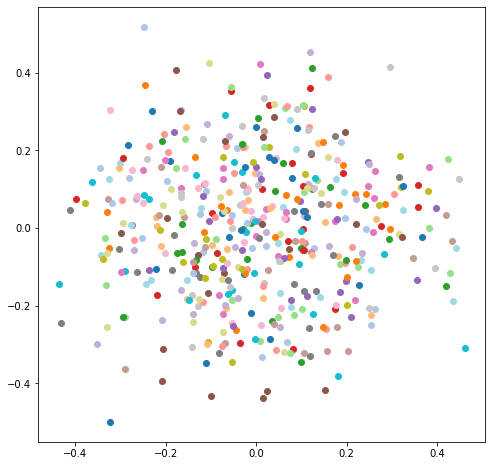

Epoch 0, train loss equals 0.9789468394645234
Epoch 1, train loss equals 0.9562416676316923
Epoch 2, train loss equals 0.9335558205175349
Epoch 3, train loss equals 0.9128345401112179
Epoch 4, train loss equals 0.8908284875638507
Validation score equals 0.03412875668143627, 2116.477792732167, 0.07581875280394795, 0.09376401973979363
Epoch 5, train loss equals 0.8636778448306761
Epoch 6, train loss equals 0.8428648913918683
Epoch 7, train loss equals 0.8198882463218822
Epoch 8, train loss equals 0.8015639053240566
Epoch 9, train loss equals 0.7847505682604254
Validation score equals 0.04609428012568943, 1863.6855091969494, 0.10139075818752805, 0.14849708389412292
Epoch 10, train loss equals 0.7659117610004588
Epoch 11, train loss equals 0.7523927759200424
Epoch 12, train loss equals 0.7291935054330502
Epoch 13, train loss equals 0.7213868169690104
Epoch 14, train loss equals 0.7027282621319301
Validation score equals 0.05786539043958757, 1738.8425302826379, 0.11754149842978914, 0.166442

In [66]:
lr = 0.01

epochs = 140
valid_freq = 5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TransE(data.num_entities, data.num_relations, device, visualize=True).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
train_losses, mrr_score_val, mr_score_val, hits_at_10_val, hits_at_20_val = train(model, data, optimizer, device, epochs=epochs, valid_freq=valid_freq)

Plot learning curve

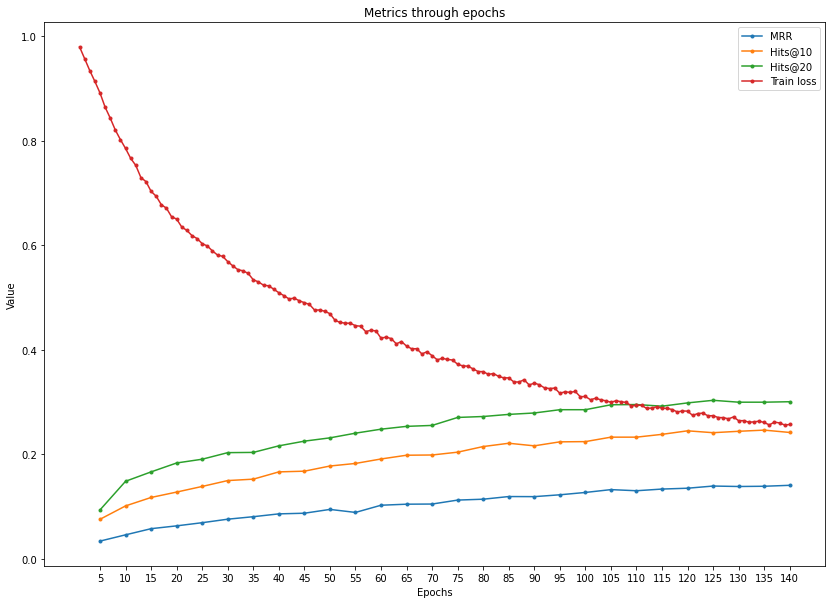

In [67]:
plt.figure(figsize=(14,10))
plt.title("Metrics through epochs")

epoch_span = [i for i in range(5,epochs+5,5)]
plt.plot(epoch_span, mrr_score_val, '.-', label="MRR")
plt.plot(epoch_span, hits_at_10_val, '.-', label="Hits@10")
plt.plot(epoch_span, hits_at_20_val, '.-', label="Hits@20")
plt.plot([i for i in range(1,epochs+1)], train_losses, '.-', label="Train loss")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.xticks(epoch_span[:])
plt.legend()
plt.show()